<a id='top'></a>
# IntraCranial pipeline

### Sections
1. [Pipeline description](#intro)
1. [Set up](#setup)
1. [Preprocessing](#preprocessing)
1. [Overview](#overview)
1. [Inference](#inference)
1. [Regresions](#regressions)
1. [Figures](#figures)
1. [Plots](#plots)
1. [Common functions](#cf)


<a id='intro'></a>
# Pipeline description

### Modules

1. **Preprocessing**: Make mne raw filesm basic cleaning (notch filter, resaple, low/high pass filter), rejection, referencing, epoching
1. **Inference**:
1. **Regressions**:

Other
1. **Figures**:
1. **Overview**: make figures with evoked responses for all channels / subjects / bands.
1. **Common functions**:


### Naming conventions

BIDS

### Folder structure

- **Code**
    - `ICPipeline.ipynb`
    - `static_parameters.py`
    - `run.py`
    - utils
        - modules
- **Data** 
    - raw
        - sub-XX 
            - `sub-XX_electrodes.json`
            - `sub-XX_runXX_events.csv`
            - `sub-XX_runXX_ieeg.csv`
            - `sub-XX_runXX_ttl.csv`
    - derivatives
        - sub-XX
            - `sub-XX_raw.fif`
            - `sub-XX_band-XXXX_raw.fif`
            - `sub-XX_band-XXXX_level-XXXX_epo.fif`
            - `sub-XX_{test}_{queries}.csv`
- **Figures**

<a id='setup'></a>
# Set up

Import necessary libraries and parameters.

Pipeline configuration is done through the [static parameters file](http://localhost:8888/edit/static_parameters.py).

In [1]:
# import packages
import numpy as np
import pandas as pd
import mne
# import sys, os, glob, csv, json, mne, time

# import local modules
import utils.common_functions as cf
import utils.figures as fg
import utils.overview as ov

# load parameters
import config as cfg

mne.set_log_level("CRITICAL")

<a id='preprocessing'></a>

# Preprocessing
Open [code](http://localhost:8888/edit/utils/preprocessing.py) for details

This module takes you all the way from source data to mne epochs.

### Main Functions
1. `csv2raw`: Combine ieeg (csv) metadata (tsv) and electrode information (json), potentially for several recording sessions, into `mne.raw`. Furthermore resample from `sp.source_srate` to `sp.srate` and apply notch filter for line noise for `sp.landline_noise` Hz and harmonics
1. `referencing`: Apply refferencing, several modes available through optional arg `referencing`
1. `raw2TFR` compute time frequency representation with hilbert or wavelet method, (optionally remove outliers, zscore, smooth with gaussian filter) and save as `mne.raw` in fif file.
1. `make_epochs`: and save as `mne.Epochs`.


### Other functions
1. `get_events_and_metadata` Colect metadata from tsv files and make mne compatible events
1. `update_metadata`: to be able to add new features to the metadata at any time.
1. `hilbert` Filter data and compute Hilbert envelope
1. `wavelet` Use wavelet method to compute freq band raw
1. `clip_n_rescale` Remove outliers with RobustScaler, zscore
1. `gaussian_filter` 



### In

Raw data (from Data/raw/sub-XX)

1. ieeg data in `csv` files one row per electrode, one column per time sample. Potentially one file per recording or per block. (`sub-XX_task-XXXX_run-XX_ieeg.csv`)
1. metadata in `tsv` files. Each metadata file has to be associated to one ieeg file
1. electrodes info in `json` file


### Out

Preprocessed data (at Data/derivatives/sub-XX)

1. `mne.raw` stored as `sub-XX_band-XXX_raw.fif`
1. `mne.Epochs` stored as 

### Examples

Full preprocessing with configuration given by `static_parameters.py`:  

`pr.csv2raw()`  
`pr.rawprep()`  
`pr.referencing()`  
`pr.raw2TFR()`  
`pr.make_epochs()`  

Compute TFR and epochs for `sub-03` and `band`:  

`pr.raw2TFR(subs=['sub-03'], bands=[band])`  
`pr.make_epochs(subs=['sub-03'], bands=[band])`  


In [2]:
import utils.preprocessing as pr

In [7]:
#pr.source2raw()
#pr.rejection()
#pr.referencing()
#pr.raw2TFR()


======== mne.raw 2 mne.rawTFR ===================================

done! elapsed time 7 min                                                        



<a id='inference'></a>

# Inference

[module](http://localhost:8888/edit/utils/inference.py) 

### Functions
1. `PCT` perform permutation cluster test 1 or 2 sample (depending on `queries`)
1. `ttest` perform ttests comparing two conditions, optionally cluster tests by metadata value or time windows
1. `PCT_figures_single_channel`
1. `ttest_figures_single_channel`
1. `single_channel_figures_wrap` wrap to make one pdf book per subject per band with one page per channel 

### Examples

ttest comparing first word vs mid word activation in sencences for three time windows in the interval (-300,600) ms:  


In [7]:
import utils.inference as nf

Run a **2 sample Percolation Cluster Test** to find channels whose responses for lists of words are significantly different from responses to sentences.  
Use (midsentence) word epochs of word-list trials and sentences in localizer blocks.  
Only broad band.

In [9]:
model1 = {
         'tag':'wordlist-sentloc',
         'queries' : ['trialtype == "sent_main"', 'trialtype == "word_list"'],
         'ep_setup': {"event_type" : [ "midwordonset" ], "tmin" : 0.,"tmax" : .6 , "level" : "word" , "xticks": [0.5*n for n in range(3)], 'int':False}
        }

model2 = {
         'tag':'localizer',
         'queries' : ['blocktype == "Localizer"'],
         'ep_setup': {"event_type" : [ "midwordonset" ], "tmin" : 0.,"tmax" : .6 , "level" : "word" , "xticks": [0.5*n for n in range(3)], 'int':False}
        }
bands=[sp.bands[0]]

In [6]:
nf.PCT(model1,bands=bands)
nf.PCT(model2,bands=bands)


======== permutation cluster test ======================================
trialtype == "sent_main"
trialtype == "word_list"
sub-14, broad 214-EL214 (214/214) e.t. 5 min, r.t. 0 min                        
======== permutation cluster test ======================================
blocktype == "Localizer"
sub-14, broad 214-EL214 (214/214) e.t. 4 min, r.t. 0 min                        


Band comparison brain map for test wordlist-sentloc


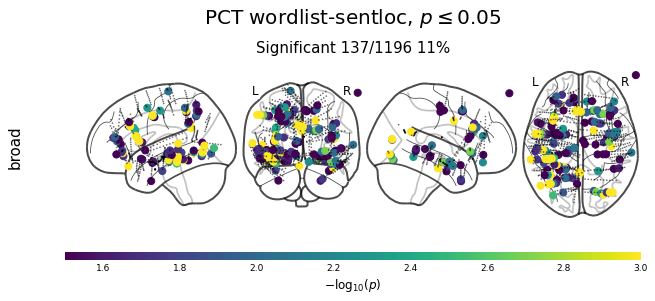

In [12]:
nf.test_maps(model1,'PCT',bands=bands, subs=sp.subject_list[:-4])
# add fdr
# high gamma

Run a **1 sample Percolation Cluster Test** to find channels that are responsive to the task.  
Use (midsentence) word epochs from localizer blocks.   
Only broad band.

### Contrast

Significant at first test (localizer) vs significant at second one (word_list vs sent_loc)


Band comparison brain map for PCT wordlist-sentloc localizer


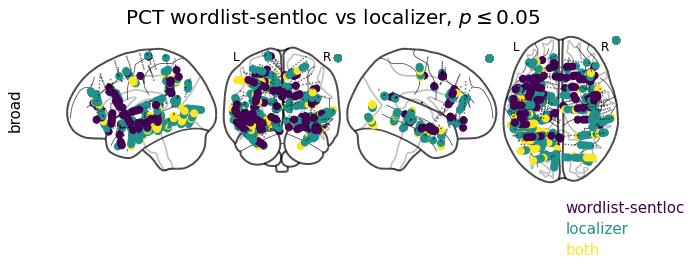

In [8]:
fg.contrast('p', 'PCT', model1, model2, bands=bands)

<a id='regressions'></a>

# Regressions

In [2]:
import utils.regressions as rg

Regression model for features:  
1. w_length
1. w_freq
1. w_position
1. w_position_end
1. opennodes
1. nodesclosing
1. is_last_word

Trained on **sent_main words except first word** from time 0 to 0.6 sec

In [4]:
model = {
         'tag':'full',
         'query' : 'trialtype == "sent_main"', 
         'predictors': ['w_length','w_freq','w_position','w_position_end','opennodes','nodesclosing','is_last_word'],
         'ep_setup': {"event_type" : [ "midwordonset", "lastwordonset" ], "tmin" : 0.,"tmax" : .6 , "level" : "word" , "xticks": [0.5*n for n in range(3)], 'int':False}
        }

In [10]:
rg.regression_wrap(model)  


======== regressions ===================================================

sub-11, bgamma 178-RMH13 (178/178) e.t. 3 min, r.t. 0 min                       

### General results ($r^2$)

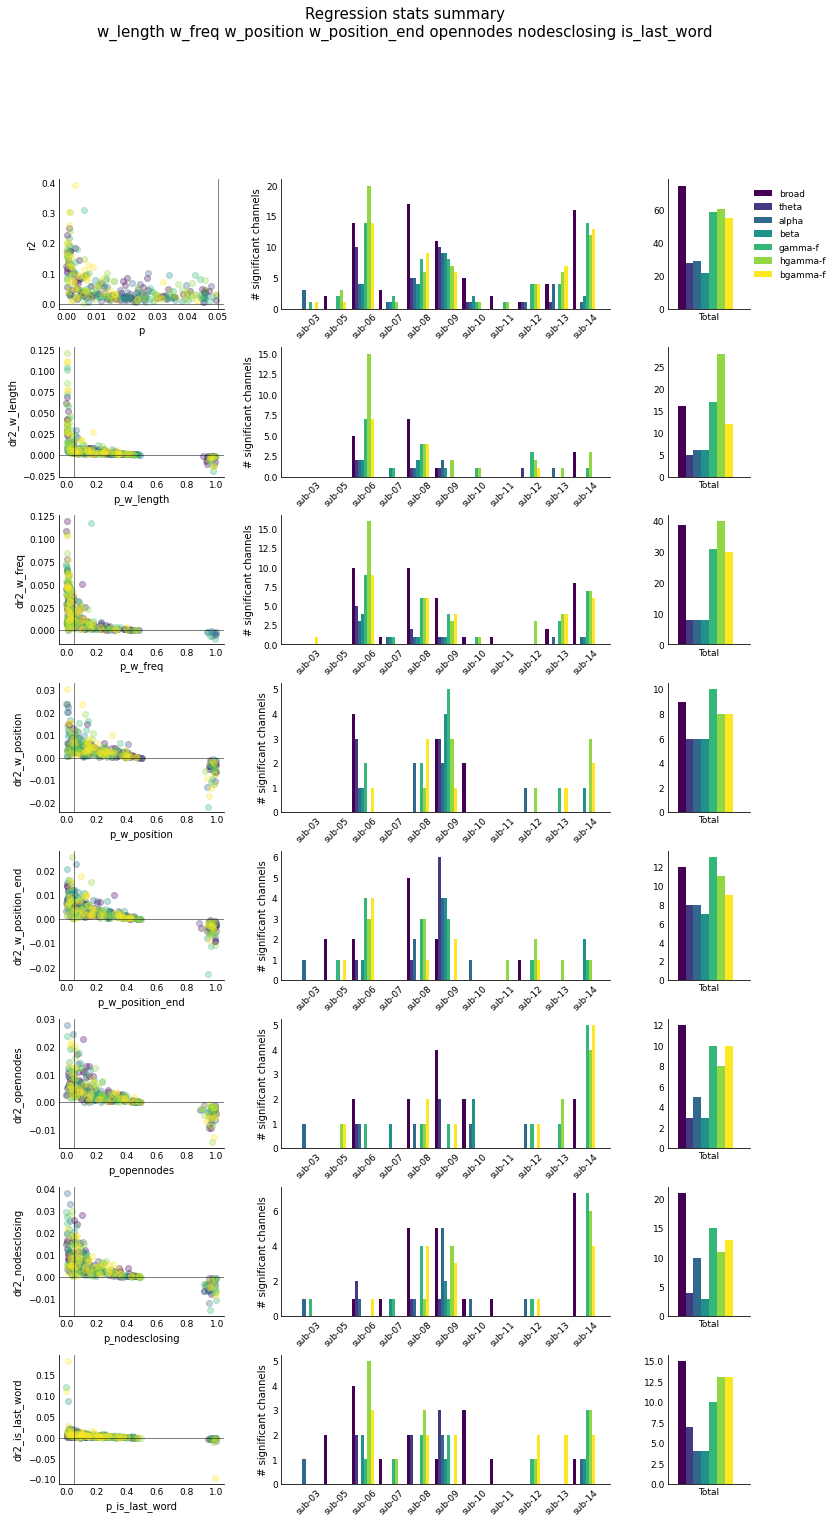


Band comparison brain map for reg full
r2


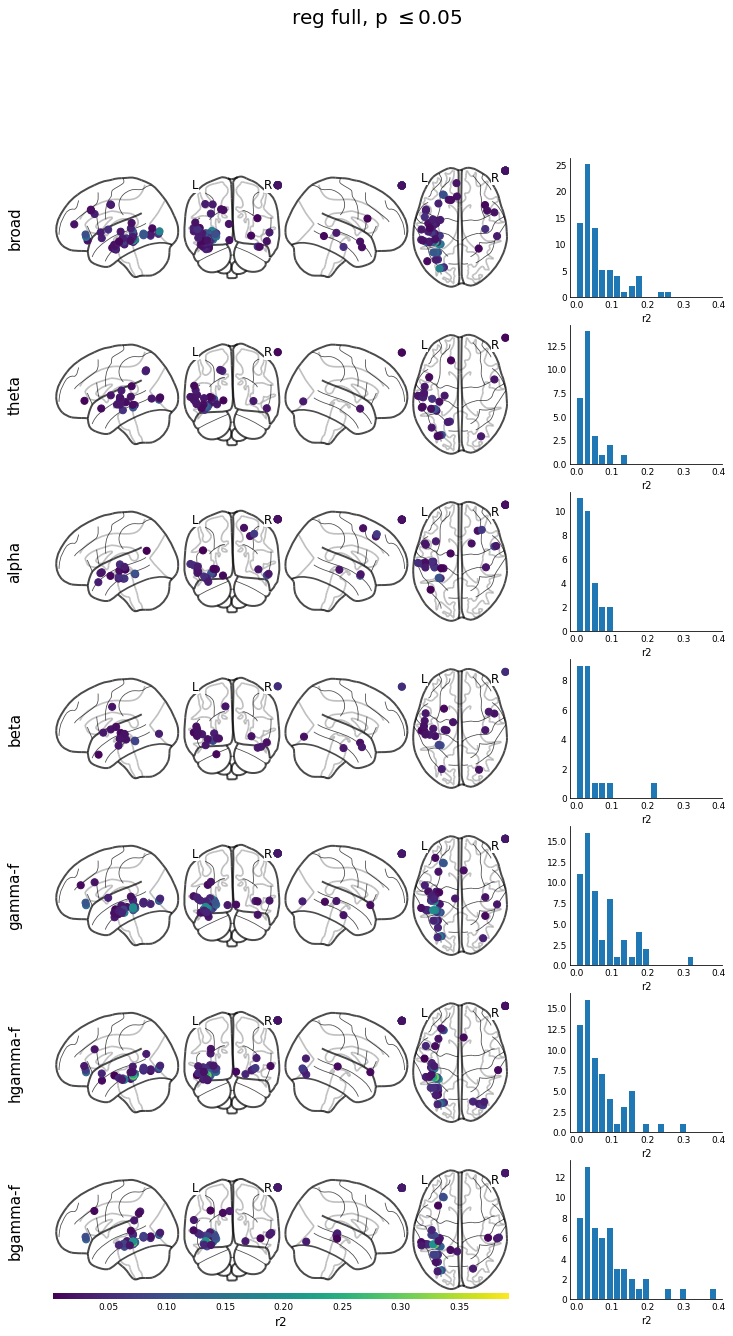

merging figures                                                                 

In [5]:
rg.reg_statistics(model,predictors='all')
#rg.reg_maps(model,predictors='all',plot=False)
rg.reg_maps(model,predictors=[])

### Analysis of syntactic features ($\Delta r^2$)

1. opennodes
1. nodesclosing
1. is_last_word


Band comparison brain map for reg full
r2


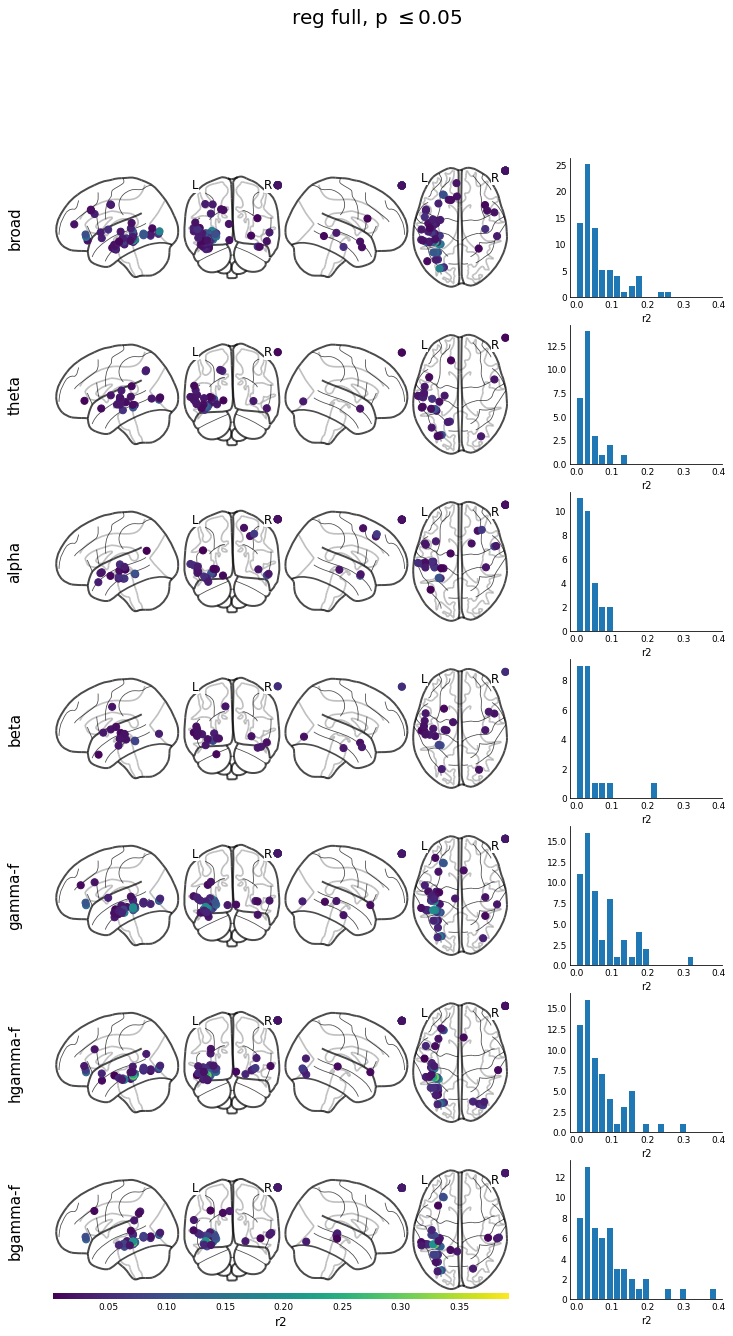

dr2_opennodes


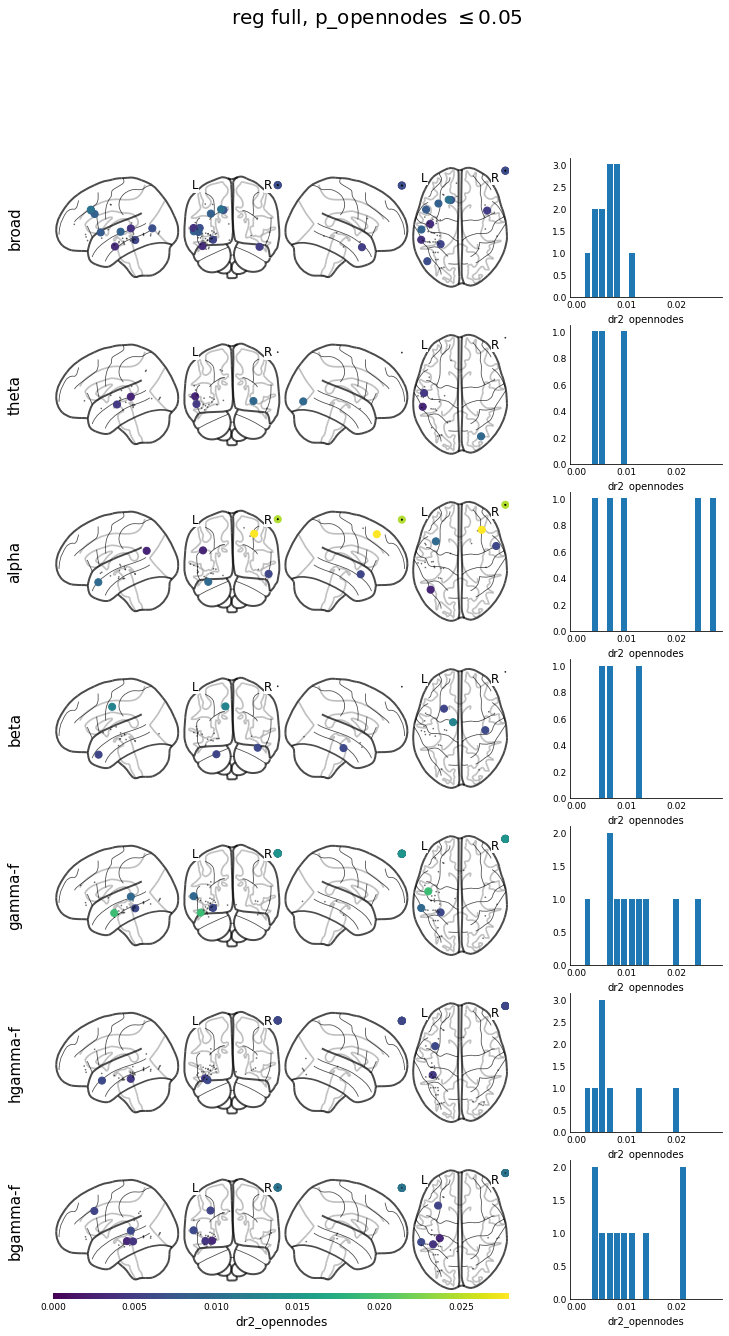

dr2_nodesclosing


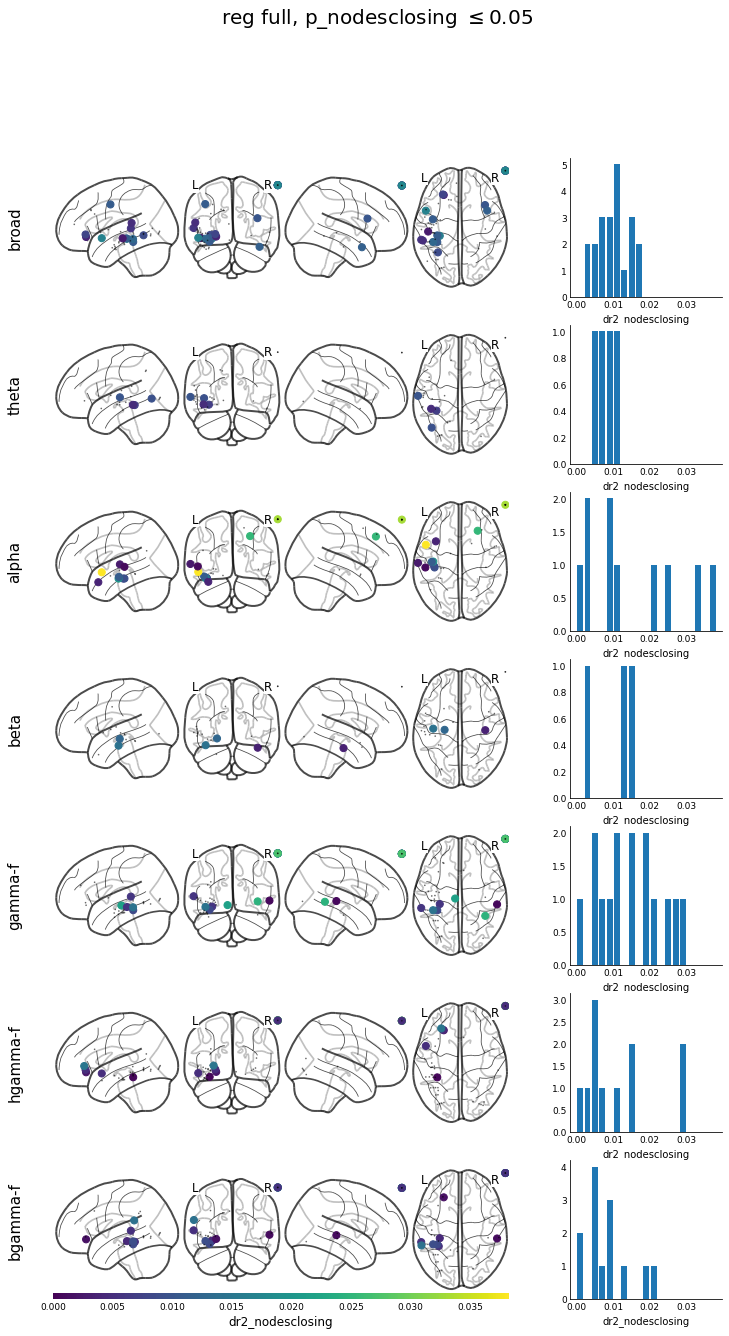

dr2_is_last_word


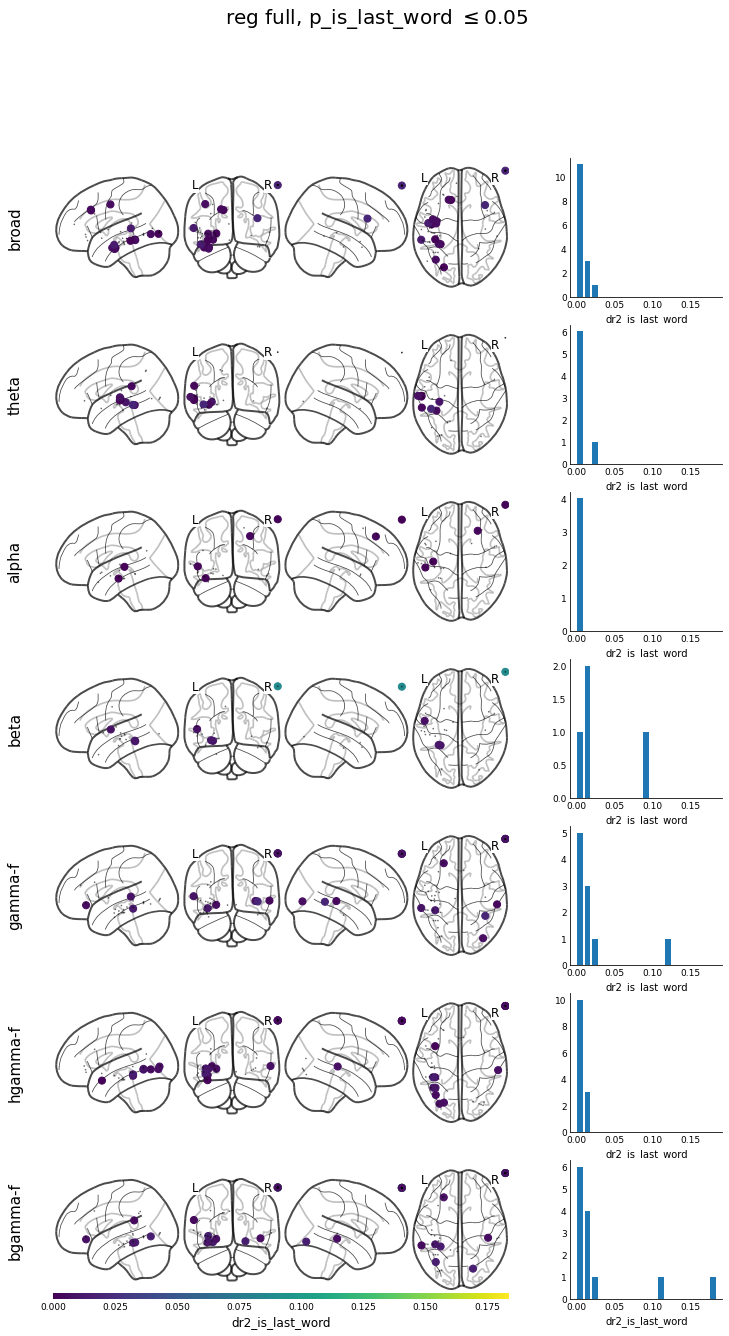

merging figures                                                                 

In [13]:
rg.reg_maps(model,predictors=['opennodes','nodesclosing','is_last_word'],save=False)

## Integral epochs

In [3]:
model_int = {
         'tag':'full_int',
         'query' : 'trialtype == "sent_main"', 
         'predictors': ['w_length','w_freq','w_position','w_position_end','opennodes','nodesclosing','is_last_word'],
         'ep_setup': {"event_type" : [ "midwordonset", "lastwordonset" ], "tmin" : 0.,"tmax" : .6 , "level" : "word" , "xticks": [0.5*n*sp.soa for n in range(3)], 'int':True}
        }

In [9]:
rg.regression_wrap(model_int)  


======== regressions ===================================================

sub-11, bgamma 178-RMH13 (178/178) e.t. 3 min, r.t. 0 min                       

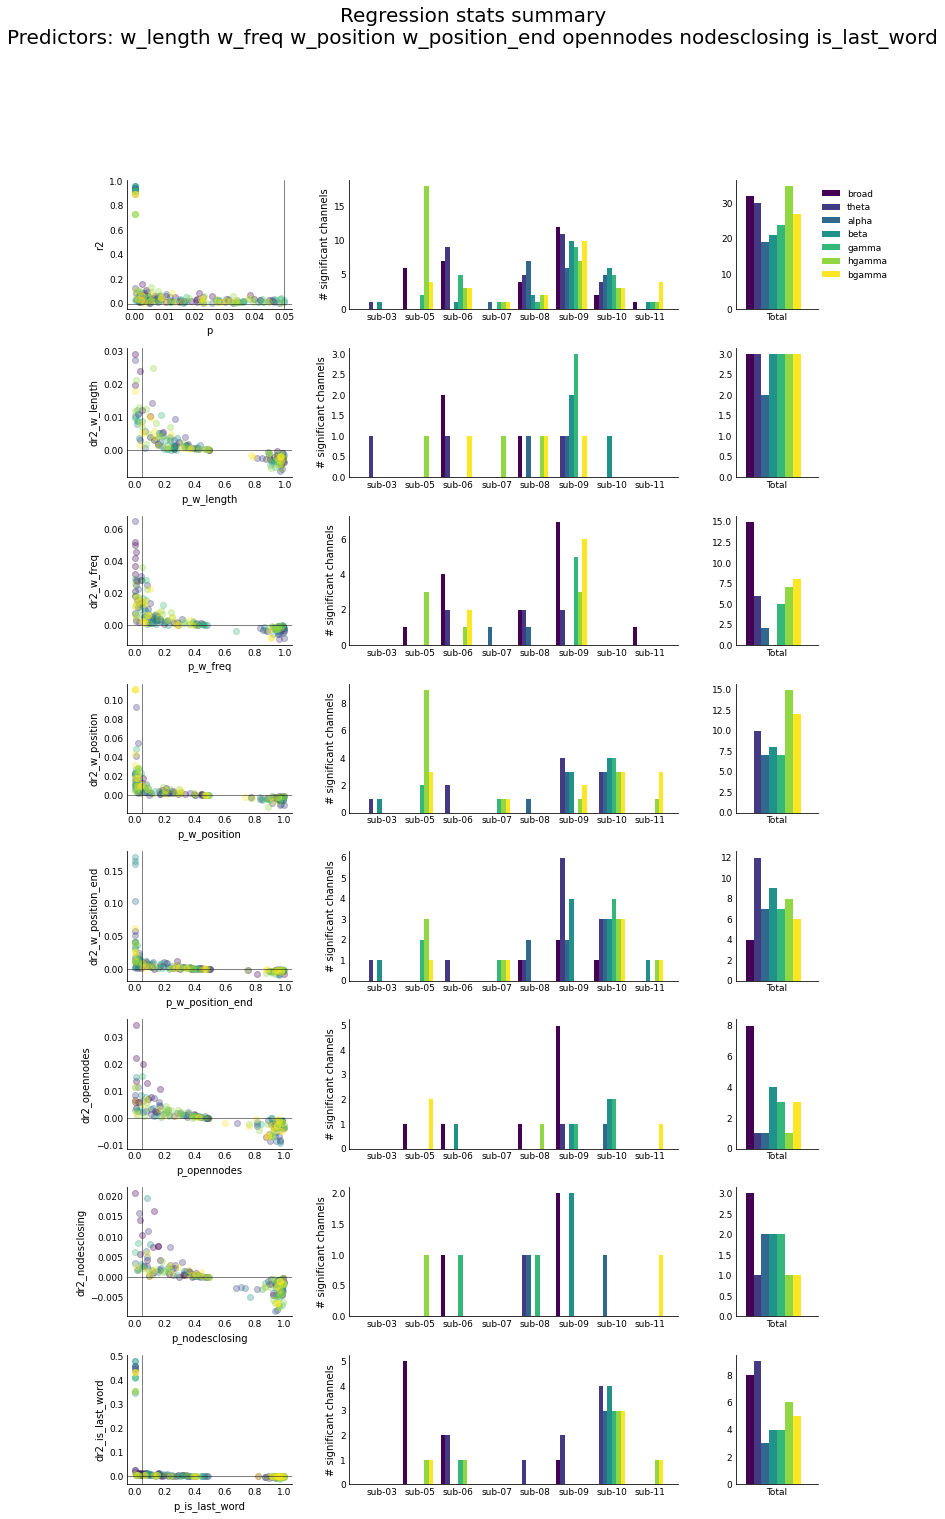


Band comparison brain map for reg full_int
r2


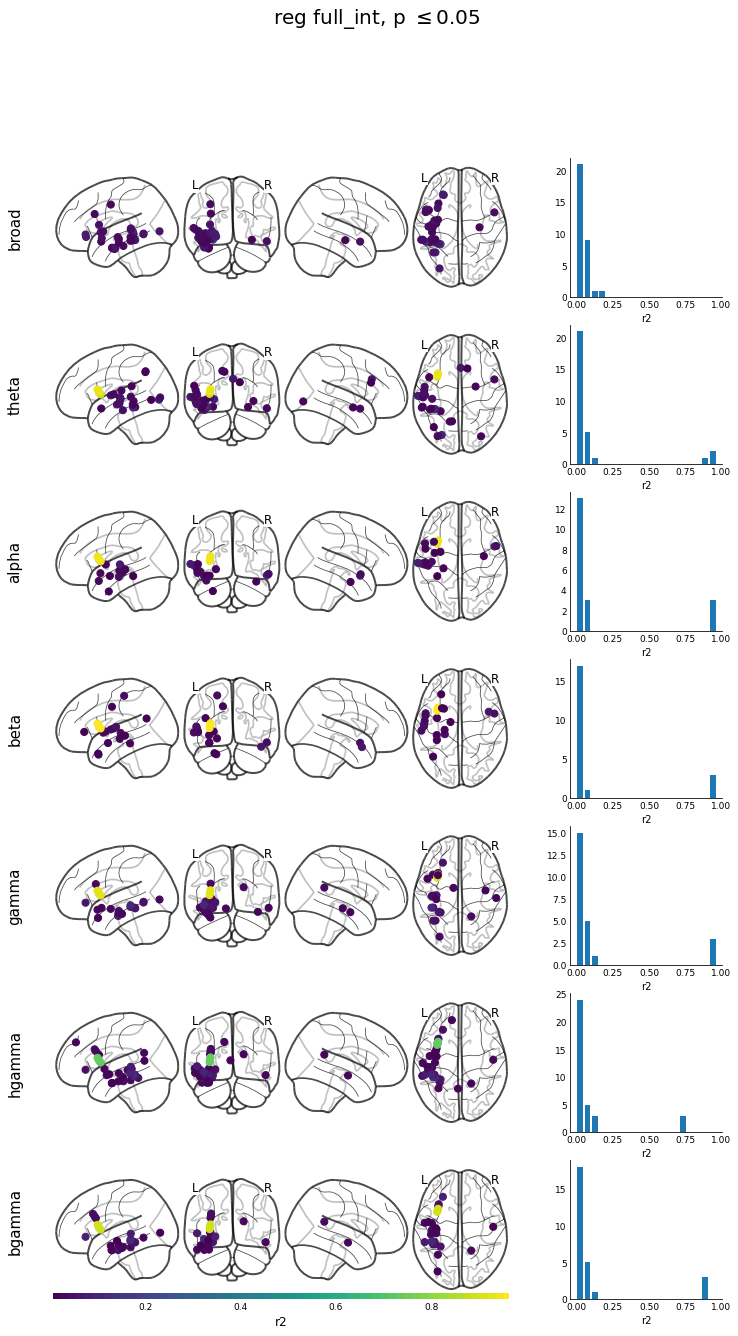

merging figures                                                                 

In [10]:
rg.reg_statistics(model_int,predictors='all')
#rg.reg_maps(model,predictors='all',plot=False)
rg.reg_maps(model_int,predictors=[])

In [4]:
rg.reg_single_channel_wrap(model_int,predictors=['opennodes','nodesclosing','is_last_word'],name='_syntactic')
rg.reg_single_channel_wrap(model_int,predictors=['w_length','w_freq'],name='_orthographic')

merging figures                                                                 

<a id='overview'></a>

# Overview
The pourpose of this [module](http://localhost:8888/edit/utils/overview.py) is to have a general overview of the dataset for sanity-checking, troubleshooting or just to get familiar with the data.
### Functions
1. `electrode_positions()`: one pdf book per subject, one page per electrode with "glass brain" and electrode positions
1. `subject_overview()`: one pdf book per subject, one page per channel per epoch setup with electrode position and average traces in all bands, either sepparated by conditions or combined (split into cathegories according to metadata field with optional arg `key`)
1. `channel_overview()`: same as previous but for a single channel


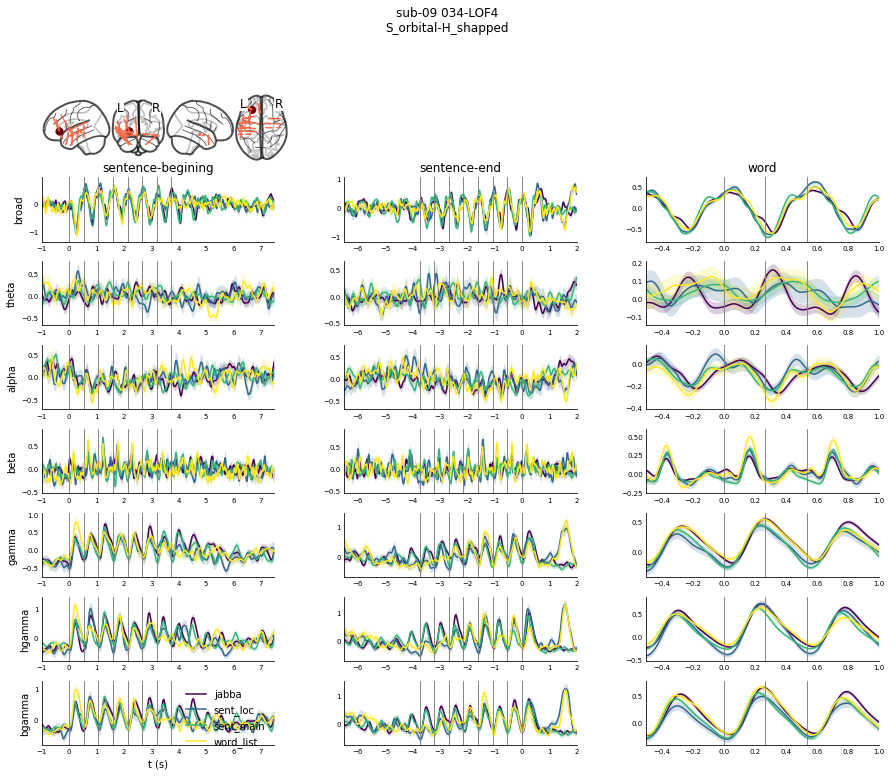

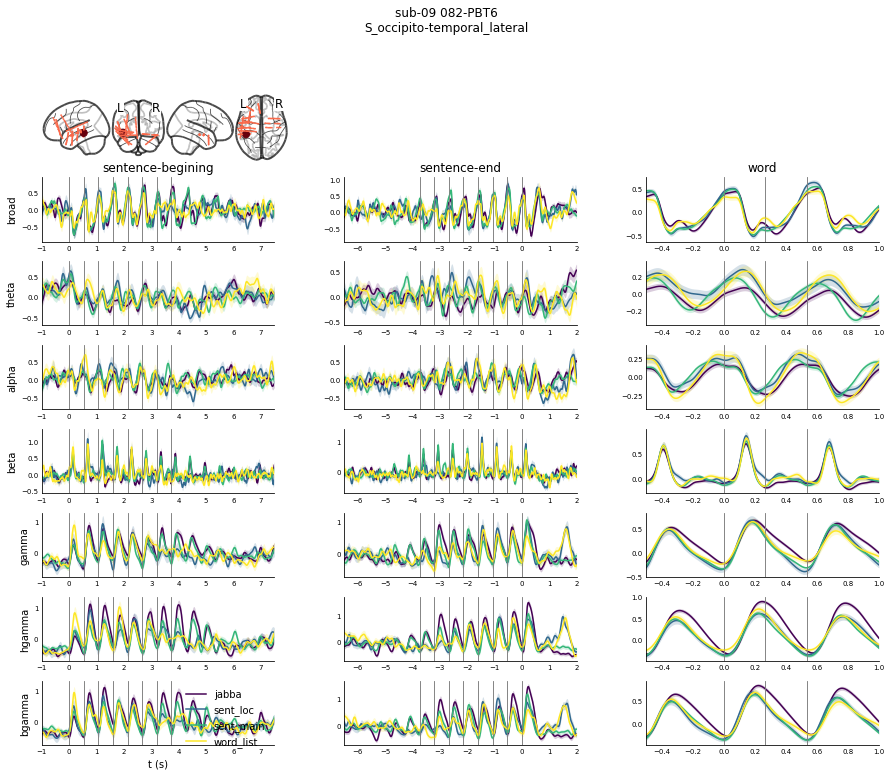

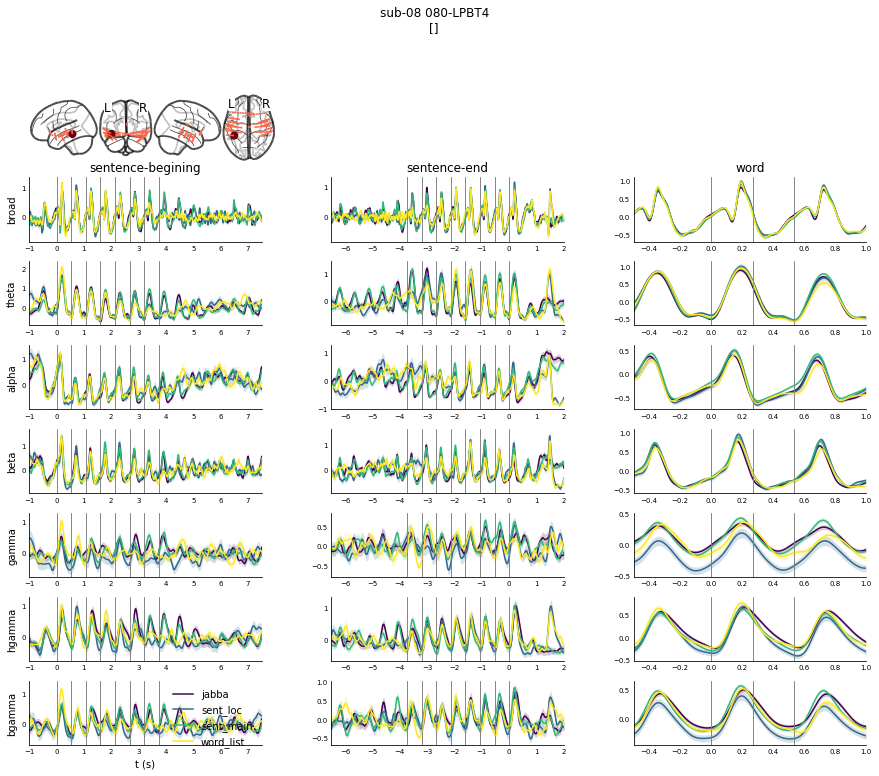

In [2]:
import utils.overview as ov

#ov.electrode_positions()
#ov.subject_overview(key='trialtype')
#ov.channel_overview('sub-05','003-LIN3',key='trialtype')
#ov.channel_overview('sub-06','060-RPSO5')
ov.channel_overview('sub-09', '034-LOF4',key='trialtype')
ov.channel_overview('sub-09', '082-PBT6',key='trialtype')
ov.channel_overview('sub-08', '080-LPBT4',key='trialtype')


Other modules


<a id='figures'></a>
# Figures
[figures.py](http://localhost:8888/edit/utils/figures.py)

to make recurrent figures, all of them take a dataframe as input with columns  
sub, ch_name, coords, p, tw 

### Functions

1. `band_comparison_brain`
    Plot variables (p_value, r2, ..., from csv files) in glass brains, one panel per band
1. `band_comparison_matrix` Scatter plots of variables (p_value, r2, ..., from csv files) in a matrix of plots comparing each pair of bands
1. `num_significant_channels` Make a bar plot with number of significant channels per subject per band for some test or regression


<a id='plots'></a>
# Plots
[plots.py](http://localhost:8888/edit/utils/plots.py)

These functions are wraps to pyplot and nilearn functions to make generic single panel plots on a pyplot ax.

### Functions

1. `brain_plot` glass brain with markers 
1. `trace_plot` time vs activation plot, posibility of splitting into conditions
1. `imshow_plot` plot 2d data with pyplot imshow
1. `bar_plot` 
1. `clear_axes` clear spines and ticks to have less cluttered plots

<a id='cf'></a>
# Common functions
[common functions.py](http://localhost:8888/edit/utils/common_functions.py)